In [ ]:
from typing import List
import sys
import numpy as np
import json
import os
import time
from tqdm import tqdm
from main import dataloader, to_vect, Coordinates, calculate_asrs
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import sklearn as skl
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from main import NeuroForestSession
import pandas as pd


Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2022\trajectories_processed
Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2024\trajectories_processed
<class 'neuroforest.dataset.ImageLoader'>


### Fonctions pour extraction des points, calcul de features, et reduction; ainsi que mushroom count

In [ ]:
import pandas as pd

def features_extraction(dataloader, session_type):
    samples = list(dataloader)
    data = []

    for sample in tqdm(samples, desc="Extracting coords & labels"):
        session = sample[session_type]  
        if session is not None:
            player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])  
            player_coords = player_coords[:, [0, 2]]  # Keep only x and z

            if player_coords.shape[0] > 29999:
                player_coords = player_coords[:29999] 

            questionnaire_data = sample["questionnaire"]
            score_sum = None
            if questionnaire_data is not None:
                score_sum = sum(int(questionnaire_data[f"asrs{i}"]) for i in range(1, 19) if f"asrs{i}" in questionnaire_data)

            data.append({"id": sample.num_id, "label": score_sum, "trajectory": player_coords,})

    return pd.DataFrame(data)


def features_computing(df_trajectories):
    features_list = []
    
    for _, row in tqdm(df_trajectories.iterrows(), total=len(df_trajectories), desc="Computing features"):
        trajectory = np.array(row['trajectory'])
        player_id = row['id']
        
        v_instant, a_instant = [], []
        angle_instant, angular_speed_instant = [], []
        angular_acceleration_instant, curvature_instant = [], []
        
        for i in range(len(trajectory) - 1):
            delta_coords = trajectory[i + 1] - trajectory[i]
            v_instant.append(delta_coords * 25)
            
            if i > 0:
                delta_v = v_instant[-1] - v_instant[-2]
                a_instant.append(delta_v * 25)
                
                P1, P2, P3 = trajectory[i - 1], trajectory[i], trajectory[i + 1]
                vec_u, vec_v = P2 - P1, P3 - P2
                norm_u, norm_v = np.linalg.norm(vec_u), np.linalg.norm(vec_v)
                
                cos_theta = np.dot(vec_u, vec_v) / (norm_u * norm_v) if norm_u != 0 and norm_v != 0 else 1.0
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                angle_instant.append(np.arccos(cos_theta))
                
                if len(angle_instant) > 1:
                    angular_speed_instant.append((angle_instant[-1] - angle_instant[-2]) * 25)
                    angular_acceleration_instant.append((angular_speed_instant[-1] - angular_speed_instant[-2]) * 25)
                else:
                    angular_speed_instant.append(0.0)
                    angular_acceleration_instant.append(0.0)
                
                x0, y0 = P1
                x1, y1 = P2
                x2, y2 = P3
                numerator = (x1 - x0) * (y2 - y1) - (x2 - x1) * (y1 - y0)
                denominator = np.sqrt(((x1 - x0)**2 + (y1 - y0)**2) * ((x2 - x1)**2 + (y2 - y1)**2))
                curvature_instant.append(numerator / denominator if denominator != 0 else 0.0)
            else:
                a_instant.append(np.array([0.0, 0.0]))
                angle_instant.append(0.0)
                angular_speed_instant.append(0.0)
                angular_acceleration_instant.append(0.0)
                curvature_instant.append(0.0)
        
        features_list.append({
            'id': player_id,
            'speed_mean': np.mean(v_instant), 'speed_var': np.var(v_instant),
            'acceleration_mean': np.mean(a_instant), 'acceleration_var': np.var(a_instant),
            'angle_mean': np.mean(angle_instant), 'angle_var': np.var(angle_instant),
            'angular_speed_mean': np.mean(angular_speed_instant), 'angular_speed_var': np.var(angular_speed_instant),
            'angular_acceleration_mean': np.mean(angular_acceleration_instant), 'angular_acceleration_var': np.var(angular_acceleration_instant),
            'curvature_mean': np.mean(curvature_instant), 'curvature_var': np.var(curvature_instant)
        })
    
    return pd.DataFrame(features_list)



            
def feature_reduction(df_features, points_per_second, original_points_per_second=25):
    interval = original_points_per_second // points_per_second
    
    reduced_features = []
    for _, row in tqdm(df_features.iterrows(), total=len(df_features), desc="Reducing features"):
        player_id = row['id']
        reduced_row = {'id': player_id}
        
        for col in df_features.columns:
            if col != 'id':
                reduced_row[col] = row[col] / interval
        
        reduced_features.append(reduced_row)
    
    return pd.DataFrame(reduced_features)

def mushroom_count(dataloader, session_type):
    sorted_samples = sorted(dataloader, key=lambda sample: sample.id)
    mushroom_data = []
    
    for sample in tqdm(sorted_samples, desc="Extracting mushrooms"):
        session = sample[session_type]
        mushroom_data.append({'id': sample.id, 'mushrooms': session.gathered_mushrooms if session else 0})
    
    return pd.DataFrame(mushroom_data)


### Exemple : creation d'un dataframe pour les trajectoires "uniformes" et d'un autre pour les features, puis merging

In [5]:
df_extraction_uniform = features_extraction(dataloader, "uniform")
df_features_uniform = features_computing(df_extraction_uniform)
df_uniform = pd.merge(df_extraction_uniform, df_features_uniform, on='id')

Extracting coords & labels:   0%|          | 0/39 [00:00<?, ?it/s]

Computing features: 100%|██████████| 39/39 [01:00<00:00,  1.56s/it]


In [6]:
df_uniform.head()

,id,trajectory,label,speed_mean,speed_var,acceleration_mean,acceleration_var,angle_mean,angle_var,angular_speed_mean,angular_speed_var,angular_acceleration_mean,angular_acceleration_var,curvature_mean,curvature_var
0,17,"[[-121.65299987792969, 195.31199645996094], [-...",20,-0.034961,1.641899,-0.001154,1.218358,0.007012,0.001300,1.310757e-05,1.187587,-5.308312e-05,2116.870802,-0.000410,0.000623
1,1,"[[-121.65299987792969, 195.31199645996094], [-...",22,0.068655,1.433755,0.000500,1.421806,0.007092,0.000803,4.420843e-06,0.786849,5.905456e-05,1504.872124,-0.000105,0.000670
2,37,"[[-121.65299987792969, 195.31199645996094], [-...",32,0.049921,1.333464,0.000019,1.424546,0.005668,0.000472,-7.563899e-20,0.335048,4.822390e-18,610.684262,-0.000149,0.000463
3,19,"[[-121.65299987792969, 195.31199645996094], [-...",49,0.135153,1.767697,0.001481,5.042894,0.018093,0.007931,2.315467e-06,4.975146,-5.420254e-04,8770.387841,-0.000775,0.003728
4,29,"[[-121.65299987792969, 195.31199645996094], [-...",36,0.067417,1.858162,0.000058,2.463325,0.012713,0.004487,3.897282e-07,4.634315,3.390394e-06,8865.762208,-0.000067,0.001883


### Plotting des distributions d'ASRS

C:\Users\kupec\AppData\Local\Temp\ipykernel_15340\1988029031.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


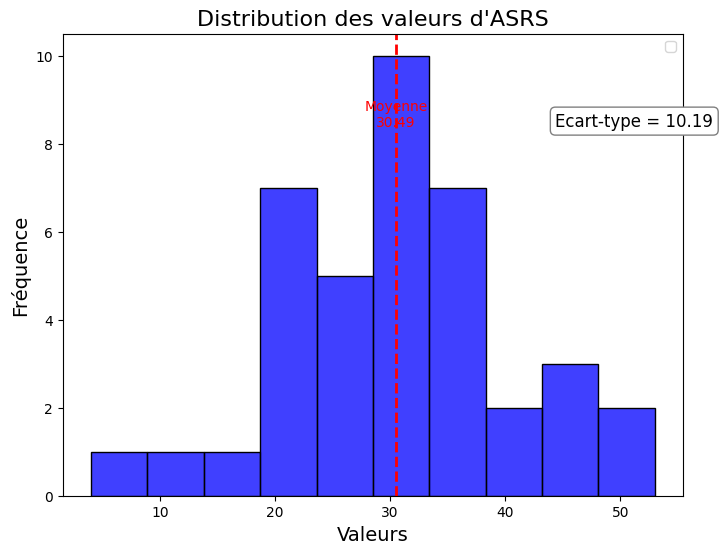

In [16]:
moyenne = np.mean(df_extraction_uniform["label"])
stf = np.std(df_extraction_uniform["label"])

# Tracer la distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_extraction_uniform["label"], kde=False, bins=10, color='blue')

# Ajouter des annotations pour la moyenne et la variance
plt.axvline(moyenne, color='red', linestyle='--', linewidth=2)
plt.text(moyenne, plt.ylim()[1]*0.8, f"Moyenne\n{moyenne:.2f}", color="red", ha="center")

plt.text(
    plt.xlim()[1]*0.8, plt.ylim()[1]*0.8,
    f"Ecart-type = {stf:.2f}",
    fontsize=12, color="black", bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray")
)

# Ajout des titres et des labels
plt.title("Distribution des valeurs d'ASRS", fontsize=16)
plt.xlabel('Valeurs', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.legend()

# Affichage du graphique
plt.show()


### Calcul des autocorrélations (pandas series)

In [17]:
def compute_autocorrelation(df: pd.DataFrame) -> pd.Series:
    """
    Calcule l'autocorrélation pour chaque trajectoire dans le DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant une colonne 'trajectory' avec les trajectoires.

    Returns:
        pd.Series: Série contenant les autocorrélations pour chaque trajectoire.
    """
    autocorrelations = []

    for trajectory in df["trajectory"]:
        if trajectory.ndim > 1:  # Si la trajectoire est en 2D (Nx2)
            trajectory_values = np.linalg.norm(trajectory, axis=1)  # Norme des coordonnées
        else:
            trajectory_values = trajectory  # Déjà en 1D

        autocorr = np.correlate(trajectory_values, trajectory_values, mode='full')  
        autocorr = autocorr[autocorr.size // 2:]  # Garder la partie positive
        autocorr /= autocorr[0]  # Normalisation

        autocorrelations.append(autocorr)

    return pd.Series(autocorrelations)


In [18]:
df_extraction_uniform["autocorrelation"] = compute_autocorrelation(df_extraction_uniform)

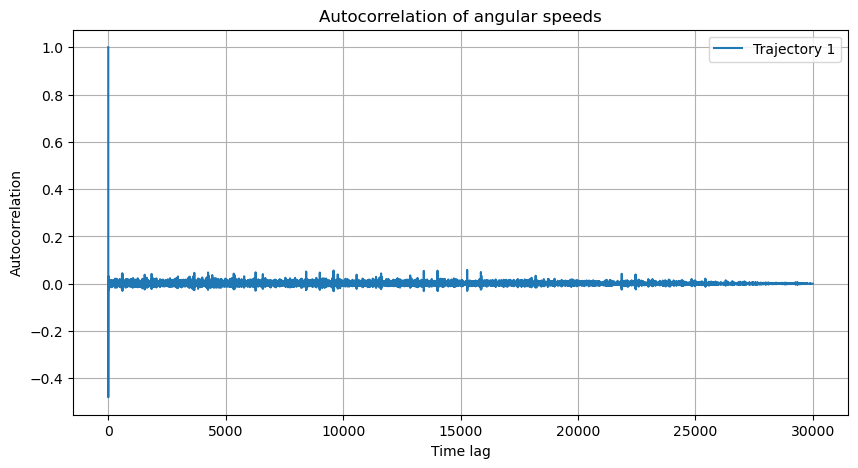

In [90]:
feature_name = "angular speeds"
autocorrelations = compute_autocorrelation(features, feature_name)

plt.figure(figsize=(10, 5))
for i, autocorr in enumerate(autocorrelations):
    plt.plot(autocorr, label=f"Trajectory {i+1}")
    break
plt.title(f"Autocorrelation of {feature_name}")
plt.xlabel("Time lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid()
plt.show()


In [3]:
names_uniform, trajectories_uniform, labels = features_extraction(dataloader, "uniform")
names_patchy, trajectories_patchy, _ = features_extraction(dataloader, "patchy")
names_first, trajectories_first, _ = features_extraction(dataloader, "first")

mushrooms_first = mushroom_count(dataloader, "first")
mushrooms_uniform = mushroom_count(dataloader, "uniform")
mushrooms_patchy = mushroom_count(dataloader, "patchy")


features_uniform = features_computing(trajectories_uniform)
features_patchy = features_computing(trajectories_patchy)
features_first = features_computing(trajectories_first)





Extracting coords & labels:   0%|          | 0/39 [00:00<?, ?it/s]

Extracting gathered mushrooms:  28%|██▊       | 11/39 [00:04<00:12,  2.19it/s]

Session patchy non trouvée pour Estelle


Computing players trajectories: 100%|██████████| 39/39 [00:22<00:00,  1.72it/s]


In [29]:
save_autocorrelations_to_csv(features_uniform, names_uniform, "results/autocorrelations_uniform.csv")
save_autocorrelations_to_csv(features_patchy, names_patchy,  "results/autocorrelations_patchy.csv")
save_autocorrelations_to_csv(features_first, names_first, "results/autocorrelations_first.csv")


Autocorrelations saved to results/autocorrelations_uniform.csv
Autocorrelations saved to results/autocorrelations_patchy.csv
Autocorrelations saved to results/autocorrelations_first.csv


In [72]:
features = features_computing(trajectories)

Computing players trajectories:  10%|█         | 4/39 [00:09<01:20,  2.29s/it]

In [30]:
from scipy.spatial import ConvexHull

def compute_convex_hull_xz(coords: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    
    mask = (points[:, 0] > -170) & (points[:, 1] > -170)
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points

def plot_convex_hull_xz(coords: List[Coordinates]):
    """
    Trace les positions et l'enveloppe convexe pour une liste de coordonnées en utilisant x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
    """
    hull, hull_points = compute_convex_hull_xz(coords)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z pour le tracé
    
    hull_points_array = np.array([p.to_vect()[[0, 2]] for p in hull_points])  # Convertir pour le tracé

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], label="Points", alpha=0.6)
    plt.plot(np.append(hull_points_array[:, 0], hull_points_array[0, 0]),
             np.append(hull_points_array[:, 1], hull_points_array[0, 1]),
             'r-', label="Enveloppe convexe")
    plt.fill(hull_points_array[:, 0], hull_points_array[:, 1],
             'r', alpha=0.2, label="Zone Convexe")
    plt.legend()
    plt.title("Enveloppe Convexe (x, z)")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.show()



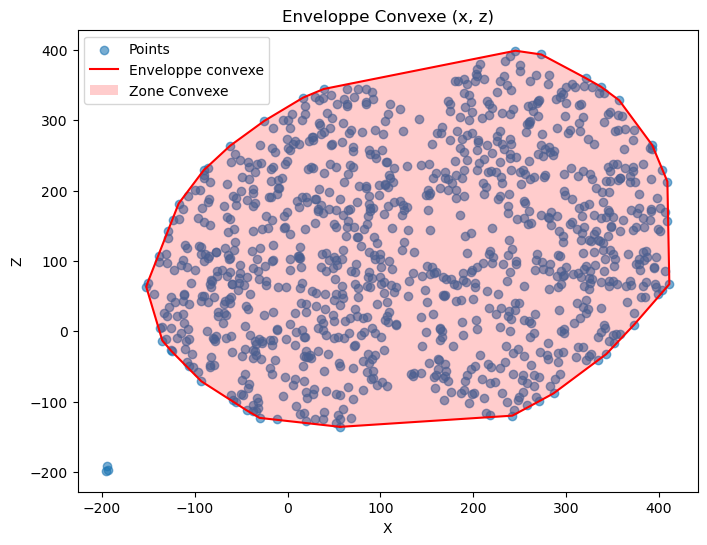

Points de l'enveloppe convexe : [array([  56.68587112,    7.14306974, -136.01805115]), array([ 242.23486328,    6.95895195, -120.10006714]), array([271.43640137,   7.30070066, -99.36813354]), array([286.64074707,   7.3095789 , -88.4002533 ]), array([343.47073364,   7.21641159, -32.532547  ]), array([373.35198975,   6.98146915,   9.12857151]), array([411.39080811,   6.97396994,  66.82357788]), array([409.28326416,   7.31017637, 212.70895386]), array([392.90740967,   7.23977709, 264.61950684]), array([357.33355713,   7.03619051, 328.25927734]), array([337.48519897,   7.1054163 , 347.75823975]), array([321.28768921,   7.19824791, 359.82675171]), array([273.40267944,   7.08209038, 393.42926025]), array([245.59143066,   7.32869101, 398.74829102]), array([ 38.86565781,   7.28945303, 344.31036377]), array([ 17.00878334,   7.11712599, 332.23522949]), array([-25.17581177,   7.07851315, 298.89273071]), array([-61.98213196,   6.96323109, 263.54071045]), array([-90.24687195,   6.98889589, 229.0358

In [31]:
sample = next(iter(dataloader))
session = sample.load_session("uniform")
coords = session.mushroom_coords
hull, hull_points = compute_convex_hull_xz(coords)

# Affichage de l'enveloppe convexe

plot_convex_hull_xz(coords)

# Points de l'enveloppe convexe
print("Points de l'enveloppe convexe :", [p.to_vect() for p in hull_points])


In [ ]:

def save_autocorrelations_to_csv(data_dict, names, csv_path="results/autocorrelations.csv"):
    """
    Sauvegarde les autocorrélations pour toutes les features et toutes les trajectoires dans un seul fichier CSV.

    Args:
        data_dict (dict): Dictionnaire contenant les autocorrélations pour chaque feature.
                         Clés = noms des features, valeurs = .
        csv_path (str): Chemin du fichier CSV où sauvegarder dictionnaires où chaque clé est l'ID de trajectoire
                         et la valeur est un array représentant l'autocorrélation les données.
    """
    # Créer le répertoire du fichier CSV s'il n'existe pas
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Construire un DataFrame à partir des données
    rows = []
    for feature_name in data_dict.keys():
        autocorrelations = compute_autocorrelation(data_dict, feature_name)
        if len(names) != len(autocorrelations):
            raise ValueError("The number of names must be equal to the number of autocorrelations.")

        for i in range(len(autocorrelations)):
        
            rows.append({"Feature": feature_name, "Trajectory ID": names[i], "Autocorrelation": autocorrelations[i]})
    df = pd.DataFrame(rows)
    
    # Sauvegarder le DataFrame dans un fichier CSV
    df.to_csv(csv_path, index=False, sep=';')
    print(f"Autocorrelations saved to {csv_path}")
           


In [34]:
from scipy.spatial import distance

def average_distance_to_hull(coords: List, trajectories: List[np.ndarray], metric : str) -> List[float]:
    """
    Calcule la distance moyenne des points d'une trajectoire aux bords de l'enveloppe convexe.

    Args:
        coords (List): Liste des positions des champignons.
        trajectories (List[np.ndarray]): Liste de trajectoires, chaque trajectoire étant un array de points (30000, 2).
        metric (str): La métrique à utiliser pour calculer les distances.
    Returns:
        List[float]: Liste des distances moyennes pour chaque trajectoire.
    """
    # Calculer l'enveloppe convexe
    hull, _ = compute_convex_hull_xz(coords)
    hull_points = hull.points[hull.vertices]  # Points de l'enveloppe convexe
    
    # Calculer les distances moyennes pour chaque trajectoire
    avg_distances = []
    for trajectory in trajectories:
        # Calculer les distances pour chaque point de la trajectoire au bord de la hull
        distances = distance.cdist(trajectory, hull_points, metric=metric)
        min_distances = np.min(distances, axis=1)  # Distance minimale pour chaque point au bord
        avg_distances.append(np.mean(min_distances))  # Moyenne des distances
    return avg_distances


In [36]:
import csv

def save_hull_distances_to_csv(coords: List, 
                               trajectories: List[np.ndarray], 
                               names : List[str],
                               metrics: List[str], 
                               output_file: str):
    """
    Calcule les distances moyennes des trajectoires à l'enveloppe convexe pour différentes métriques
    et les écrit dans un fichier CSV.

    Args:
        coords (List): Liste des positions des champignons.
        trajectories (List[np.ndarray]): Liste de trajectoires, chaque trajectoire étant un array (N, 2).
        names (List[str]): Liste des noms des joueurs.
        metrics (List[str]): Liste des métriques à utiliser pour le calcul des distances ('euclidean', 'cityblock', etc.).
        output_file (str): Nom du fichier CSV à générer.
    """
    # Récupérer l'enveloppe convexe
    hull, _ = compute_convex_hull_xz(coords)
    hull_points = hull.points[hull.vertices]  # Points de l'enveloppe convexe

    # Initialiser les résultats
    results = []

    for i in range(len(trajectories)):
        distances_by_metric = {"trajectory_index": names[i]}
        for metric in metrics:
            # Calculer les distances pour la métrique spécifiée
            distances = distance.cdist(trajectories[i], hull_points, metric=metric)
            min_distances = np.min(distances, axis=1)  # Distance minimale pour chaque point
            distances_by_metric[metric] = np.mean(min_distances)  # Moyenne des distances pour la métrique
        results.append(distances_by_metric)

    # Écrire les résultats dans un fichier CSV
    with open(output_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["trajectory_index"] + metrics, delimiter=';')
        writer.writeheader()
        writer.writerows(results)
        
save_hull_distances_to_csv(coords, trajectories_first, names_first, ["euclidean", "cityblock", "chebyshev"], "results/edge_distances_first.csv")
save_hull_distances_to_csv(coords, trajectories_uniform, names_uniform,["euclidean", "cityblock", "chebyshev"], "results/edge_distances_uniform.csv")
save_hull_distances_to_csv(coords, trajectories_patchy, names_patchy, ["euclidean", "cityblock", "chebyshev"], "results/edge_distances_patchy.csv")



In [37]:
def write_diameter_to_csv(trajectory, names, output_file):
    if len(trajectory) != len(names):
        raise ValueError("The number of trajectories must be equal to the number of names.")
    else:
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow(["trajectory_index", "diameter"])
            for i in range(len(trajectories)):
                diameter = np.max(distance.pdist(trajectories[i], metric='euclidean'))
                writer.writerow([names[i], diameter])
                
write_diameter_to_csv(trajectories_first, names_first, "results/diameter_first.csv")
write_diameter_to_csv(trajectories_uniform, names_uniform, "results/diameter_uniform.csv")
write_diameter_to_csv(trajectories_patchy, names_patchy, "results/diameter_patchy.csv")

IndexError: list index out of range

In [40]:
def compute_convex_hull_xz_with_polyline_limit(coords: List[Coordinates], polyline: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z,
    tout en excluant les points à droite de la pseudo-ligne définie par les points de la polyline.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
        polyline (List[Coordinates]): Liste des points qui définissent la pseudo-ligne de séparation.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    # Convertir les points de la polyline en numpy
    polyline_points = np.array([p.to_vect()[[0, 2]] for p in polyline])
    
    # Initialisation du masque pour filtrer les points
    mask = np.ones(len(points), dtype=bool)
    
    # Pour chaque segment de la polyline, déterminer de quel côté chaque point se trouve
    for i in range(len(polyline_points) - 1):
        p1 = polyline_points[i]
        p2 = polyline_points[i + 1]
        
        # Calculer le vecteur directeur du segment
        direction = p2 - p1
        
        # Calculer le vecteur normal au segment
        normal = np.array([direction[1], -direction[0]])  # Normal à la ligne (x, z)
        
        # Appliquer le produit scalaire pour déterminer si les points sont à gauche ou à droite du segment
        mask &= np.dot(points - p1, normal) >= 0  # Seulement à gauche ou sur la ligne
    
    # Filtrer les points
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points


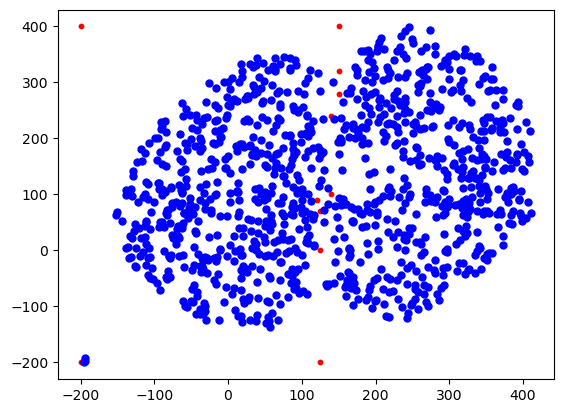

In [41]:
point1 = Coordinates(x=150, y=0, z=400)
point2 = Coordinates(x=150, y=0, z=320)
point3 = Coordinates(x=150, y=0, z=280)
point4 = Coordinates(x=140,y=0, z=240)
point5 = Coordinates(x=140,y=0, z=100)
point6 = Coordinates(x=120,y=0, z=90)
point7 = Coordinates(x=125,y=0, z=70)
point8 = Coordinates(x=125,y=0, z=0)
point9 = Coordinates(x=125,y=0, z=-200)
point10 = Coordinates(x=-200,y=0, z=-200)
point11 = Coordinates(x=-200,y=0, z=400)
river_points = [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11]

# 2 last point are made to define a closed polygon
for p in river_points:
    plt.scatter(p.to_vect()[0], p.to_vect()[2], color='red', s=10)

for mushroom in coords:
    plt.plot(mushroom.to_vect()[0], mushroom.to_vect()[2], color = 'blue', marker = 'o', markersize = 5) 

plt.show()



    


In [42]:
from shapely.geometry import Point, Polygon

def count_points_in_and_out(trajectory, river_points):
    """
    Compte le nombre de points d'une trajectoire à l'intérieur et à l'extérieur de la polyligne.
    
    Arguments:
    - trajectory: Liste de points représentant la trajectoire.
    - river_points: Liste des points qui définissent la polyligne de séparation (la rivière).
    
    Retour:
    - Compte des points à l'intérieur et à l'extérieur de la polyligne.
    """
    # Créer le polygone de la rivière à partir de la polyligne
    river_coords = [(p.to_vect()[0], p.to_vect()[2]) for p in river_points]
    polygon = Polygon(river_coords)

    inside_count = 0
    outside_count = 0

    # Vérifier pour chaque point de la trajectoire
    for p in trajectory:
        point = Point(p[0], p[1])  # Créer un objet Point
        if polygon.contains(point):
            inside_count += 1
        else:
            outside_count += 1

    return inside_count, outside_count

def plot_trajectory_with_river(trajectory, river_points, inside_count, outside_count):
    """
    Trace la trajectoire et la polyligne de la rivière avec le nombre de points à l'intérieur et à l'extérieur de la ligne.
    """
    # Tracer la polyligne de la rivière
    river_x = [p.to_vect()[0] for p in river_points[:-2]]
    river_z = [p.to_vect()[2] for p in river_points[:-2]]
    plt.plot(river_x, river_z, color='red', label="Rivière", lw=2)

    # Tracer la trajectoire
    trajectory_x = [p[0] for p in trajectory]
    trajectory_z = [p[1] for p in trajectory]
    plt.plot(trajectory_x, trajectory_z, color='blue', label="Trajectoire")

    # Affichage des résultats
    plt.title(f"Trajectoire - Points à gauche: {inside_count}, Points à droite: {outside_count}")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.legend()
    plt.show()


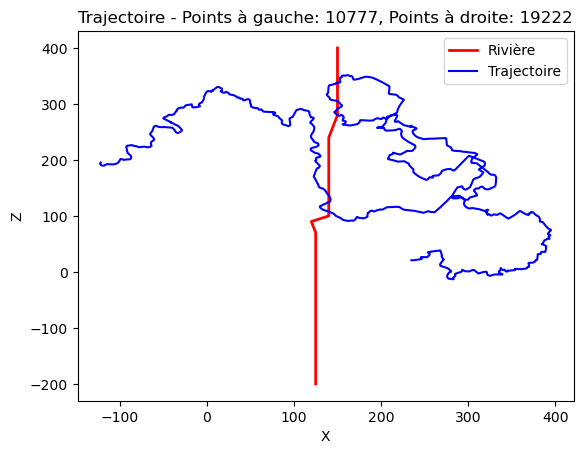

In [43]:
left_count, right_count = count_points_in_and_out(trajectories_patchy[0], river_points)

# Tracer le graphique
plot_trajectory_with_river(trajectories_patchy[0], river_points, left_count, right_count)


In [44]:
def write_side_ratio_to_csv(trajectory, names, output_file):
    if len(trajectory) != len(names):
        raise ValueError("The number of trajectories must be equal to the number of names.")
    else:
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow(["trajectory_index", "Time spent on the left side", "Time spent on the right side", "Total time"])
            for i in range(len(trajectories)):
                left = count_points_in_and_out(trajectories[i], river_points)[0]/25
                right = count_points_in_and_out(trajectories[i], river_points)[1]/25
                total = left + right
                writer.writerow([names[i], left, right, total])
                
write_side_ratio_to_csv(trajectories_first, names_first, "results/side_ratio_first.csv")
write_side_ratio_to_csv(trajectories_uniform, names_uniform, "results/side_ratio_uniform.csv")
write_side_ratio_to_csv(trajectories_patchy, names_patchy, "results/side_ratio_patchy.csv")



IndexError: list index out of range

In [46]:
def write_mushroom_count_to_csv(mushrooms, names, output_file):
    if len(mushrooms) != len(names):
        raise ValueError("The number of mushroom counts must be equal to the number of names.")
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["trajectory_index", "mushroom_count"])
        for i in range(len(mushrooms)):
            writer.writerow([names[i], len(mushrooms[i])])
            
write_mushroom_count_to_csv(mushrooms_first, names_first, "results/mushroom_count_first.csv")
write_mushroom_count_to_csv(mushrooms_uniform, names_uniform,  "results/mushroom_count_uniform.csv")
write_mushroom_count_to_csv(mushrooms_patchy, names_patchy, "results/mushroom_count_patchy.csv")


In [9]:
import csv
def write_label_to_csv(names, labels):
    if len(names) != len(labels):
        raise ValueError("The number of names must be equal to the number of labels.")
    with open("results/labels.csv", mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["trajectory_index", "label"])
        for i in range(len(names)):
            writer.writerow([names[i], labels[i]])

In [10]:
write_label_to_csv(names, labels)

In [10]:
def calculate_length(trajectory):
    """
    Calcule la longueur totale d'une trajectoire.

    Args:
        trajectory (np.ndarray): Trajectoire représentée par un array de points (N, 2).

    Returns:
        float: Longueur totale de la trajectoire.
    """
    # Calculer la distance entre chaque point consécutif
    distances = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
    return np.sum(distances)

In [22]:
import csv
def write_length_to_csv(trajectories, names, output_file):
    if len(trajectories) != len(names):
        raise ValueError("The number of features must be equal to the number of names.")
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["trajectory_index", "Total length"])
        for i in range(len(trajectories)):
            writer.writerow([names[i], calculate_length(trajectories[i])])
            
write_length_to_csv(trajectories_first, names_first, "results/length_first.csv")
write_length_to_csv(trajectories_uniform, names_uniform, "results/length_uniform.csv")
write_length_to_csv(trajectories_patchy, names_patchy, "results/length_patchy.csv")


In [8]:
print((features_uniform["speeds"][0]))

[array([[-0.13847351,  0.09231567],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [ 2.64434814,  1.00355148],
       [ 2.64453888,  1.00345612],
       [ 2.64434814,  1.00345612]]), -0.03866557876573689, 3.1242653159147977]


In [98]:
features_reduced = feature_reduction(features, 5)

  Obtaining dependency information for xlsxwriter from https://files.pythonhosted.org/packages/a7/ea/53d1fe468e63e092cf16e2c18d16f50c29851242f9dd12d6a66e0d7f0d02/XlsxWriter-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/159.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/159.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/159.9 kB ? eta -:--:--
   -------------- ------------------------ 61.4/159.9 kB 544.7 kB/s eta 0:00:01
   ---------------------------------------- 159.9/159.9 kB 1.1 MB/s eta 0:00:00


Reducing curvatures for each player: 100%|██████████| 39/39 [00:02<00:00, 15.41it/s]


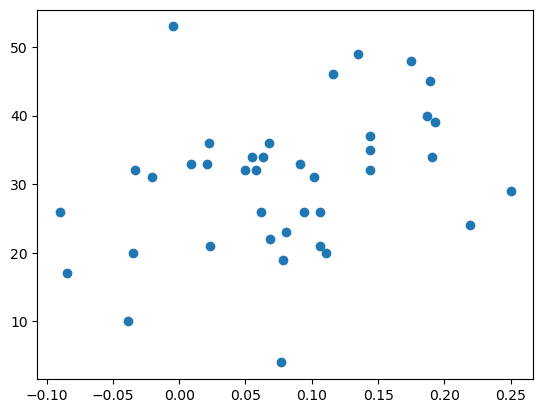

In [36]:
mean_speeds = [features_reduced["speeds"][i][1] for i in range(len(features_reduced["speeds"]))]
var_speeds = [features_reduced["speeds"][i][2] for i in range(len(features_reduced["speeds"]))]
mean_accelerations = [features_reduced["accelerations"][i][1] for i in range(len(features_reduced["accelerations"]))]
var_accelerations = [features_reduced["accelerations"][i][2] for i in range(len(features_reduced["accelerations"]))]
mean_angles = [features_reduced["angles"][i][1] for i in range(len(features_reduced["angles"]))]
var_angles = [features_reduced["angles"][i][2] for i in range(len(features_reduced["angles"]))]
mean_angular_speeds = [features_reduced["angular speeds"][i][1] for i in range(len(features_reduced["angular speeds"]))]
var_angular_speeds = [features_reduced["angular speeds"][i][2] for i in range(len(features_reduced["angular speeds"]))]
mean_angular_accelerations = [features_reduced["angular accelerations"][i][1] for i in range(len(features_reduced["angular accelerations"]))]
var_angular_accelerations = [features_reduced["angular accelerations"][i][2] for i in range(len(features_reduced["angular accelerations"]))]
mean_curvatures = [features_reduced["curvatures"][i][1] for i in range(len(features_reduced["curvatures"]))]
var_curvatures = [features_reduced["curvatures"][i][2] for i in range(len(features_reduced["curvatures"]))]


plt.plot(mean_speeds, labels, 'o')


   Mean speeds  Variance speeds  Mean accelerations  Variance accelerations  \
0    -0.038666         3.124265            0.001558               10.148722   
1     0.020886         2.406224           -0.001041                5.963116   
2     0.054548         1.417957            0.000894                1.845645   
3     0.135153         1.767697            0.001500                5.043182   
4    -0.004791         2.080101           -0.000434                3.601366   

   Mean angles  Variance angles  Mean angular speeds  Variance angular speeds  \
0     0.024486         0.007678         1.993820e-08                 8.164316   
1     0.031049         0.002762         2.396239e-05                 1.685734   
2     0.009328         0.001952         1.588963e-07                 1.780762   
3     0.018093         0.007931         2.315467e-06                 4.975146   
4     0.021097         0.002788         7.240326e-09                 2.309084   

   Mean angular accelerations  Varianc

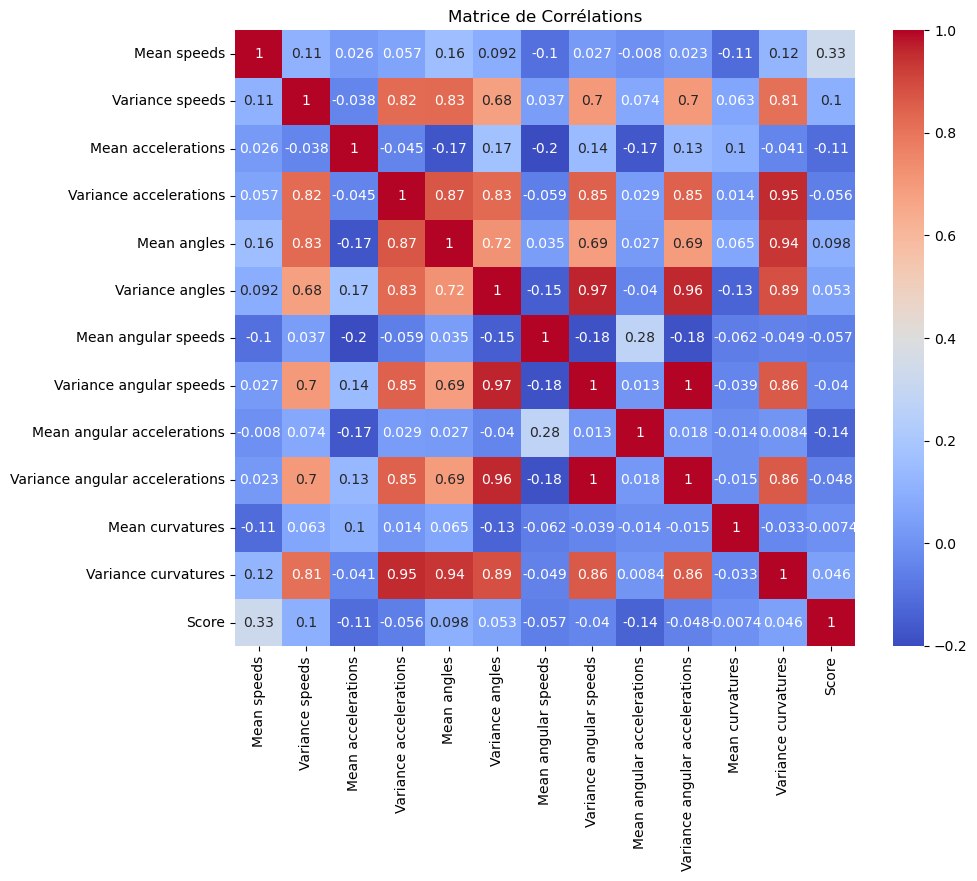

MSE: 130.28
R²: 0.07

Coefficients de régression :
                           Variable    Coefficient
11             Variance curvatures    8226.589855
5                  Variance angles    5687.617441
10                 Mean curvatures    5274.254287
0                      Mean speeds      29.871415
1                  Variance speeds      12.299419
7          Variance angular speeds       9.130493
9   Variance angular accelerations      -0.008330
3           Variance accelerations      -4.025559
4                      Mean angles    -943.548346
2               Mean accelerations   -4660.652682
8       Mean angular accelerations   -5923.222353
6              Mean angular speeds -109787.288036


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge


from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame({'Mean speeds' : mean_speeds, 'Variance speeds' : var_speeds, 'Mean accelerations' : mean_accelerations, 'Variance accelerations' : var_accelerations, 'Mean angles' : mean_angles, 'Variance angles' : var_angles, 'Mean angular speeds' : mean_angular_speeds, 'Variance angular speeds' : var_angular_speeds, 'Mean angular accelerations' : mean_angular_accelerations, 'Variance angular accelerations' : var_angular_accelerations, 'Mean curvatures' : mean_curvatures, 'Variance curvatures' : var_curvatures, 'Score' : labels})

print(data.head())


plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélations')
plt.show()

X = data.drop(columns=['Score'])
y = data['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Afficher les coefficients de régression
coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nCoefficients de régression :\n", coefficients)


MSE: 117.48
R²: 0.17

Feature importance :
                           Variable  Importance
0                      Mean speeds    0.267757
1                  Variance speeds    0.266308
8       Mean angular accelerations    0.120575
10                 Mean curvatures    0.070906
5                  Variance angles    0.063644
6              Mean angular speeds    0.045145
9   Variance angular accelerations    0.043605
3           Variance accelerations    0.029934
11             Variance curvatures    0.025394
4                      Mean angles    0.024723
2               Mean accelerations    0.022562
7          Variance angular speeds    0.019447


C:\Users\kupec\AppData\Local\Temp\ipykernel_18644\4143473667.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=feature_importances, palette='viridis')


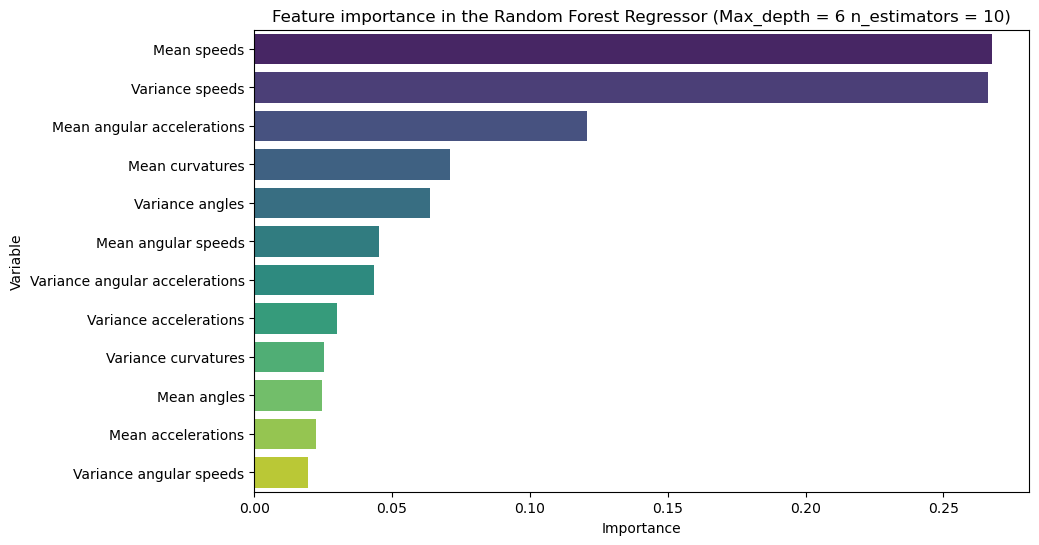

In [64]:
from sklearn.ensemble import RandomForestRegressor



# Séparation des variables explicatives et cible
X = data.drop(columns=['Score'])
y = data['Score']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=10, max_depth=6)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Afficher l'importance des variables
feature_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature importance :\n", feature_importances)

# Graphique des importances des variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=feature_importances, palette='viridis')
plt.title("Feature importance in the Random Forest Regressor (Max_depth = 6 n_estimators = 10)")
plt.show()




In [58]:
from sklearn.model_selection import GridSearchCV
X = data.drop(columns=['Score'])
y = data['Score']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition de l'espace de recherche des hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],         # Nombre d'arbres
    'max_depth': [10, 20, 30, None],       # Profondeur maximale
    'max_features': ['sqrt', 'log2', None] # Méthode de sélection des caractéristiques
}

# Initialisation du modèle
rf = RandomForestRegressor(random_state=42)

# Initialisation de GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                         # Validation croisée à 5 plis
    scoring='neg_mean_squared_error',  # Mesure de performance
    n_jobs=-1,                    # Utilisation de tous les cœurs disponibles
    verbose=1                     # Affiche la progression
)

# Lancement de la recherche
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Évaluation du modèle avec les meilleurs paramètres
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
MSE: 129.83
R²: 0.08


In [7]:
#Creation of training & testing set
threshold = 25 #Threshold for binary classification
X = np.zeros((len(features_reduced["speeds"]), 12))
temp_list = list(features_reduced.values())
# Pour chaque feature du dictionnaire
for i in range(len(temp_list)):
    for j in range(len(temp_list[i])):
        X[j, i] = temp_list[i][j][1]
        X[j, i + 6] = temp_list[i][j][2]

y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_train_tensor_binary = (y_train_tensor > threshold).float()
y_test_tensor_binary = (y_test_tensor > threshold).float()

print(f"Forme de X_train_tensor: {X_train_tensor.shape}")
print(f"Forme de y_train_tensor: {y_train_tensor.shape}")
print(f"Forme de y_train_tensor_binary: {y_train_tensor_binary.shape}")




Forme de X_train_tensor: torch.Size([31, 12])
Forme de y_train_tensor: torch.Size([31, 1])
Forme de y_train_tensor_binary: torch.Size([31, 1])


In [41]:
class BinaryClassification(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassification, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.linear(x)
        #x = self.sigmoid(x)
        return x
    def reset_weights(self):
        torch.nn.init.xavier_uniform_(self.linear.weight)


binary_model = BinaryClassification(input_dim=12)
binary_model.reset_weights()
binary_criterion = nn.BCELoss()  
optimizer = optim.SGD(binary_model.parameters(), lr=0.001) 

In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self, dim_1):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(dim_1, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        return x
    def reset_weights(self):
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.zeros_(self.linear3.bias)




In [18]:
linear_model = LinearRegressionModel(dim_1=12)
print(linear_model(X_train_tensor[0]).shape)
print(y_train_tensor[0].shape)
print(linear_model(X_test_tensor[0]).shape)
print(y_test_tensor[0].shape)

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


Training finished
Final training loss:  388.2862612745094
Final validation loss:  698.9071979522705


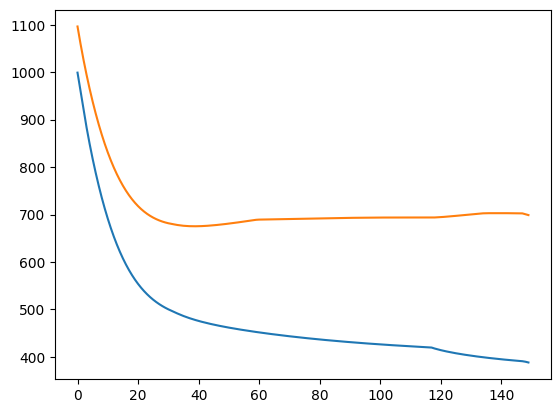

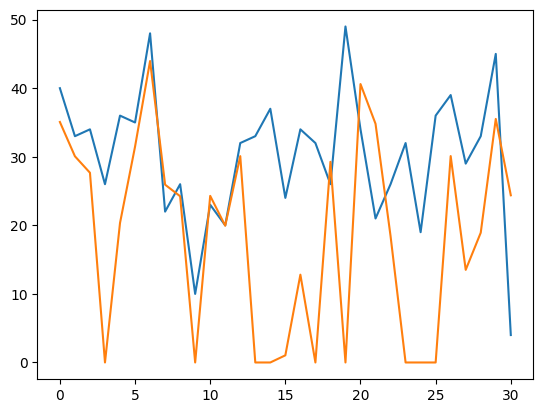

tensor([30.0713], grad_fn=<ReluBackward0>) tensor([40.])


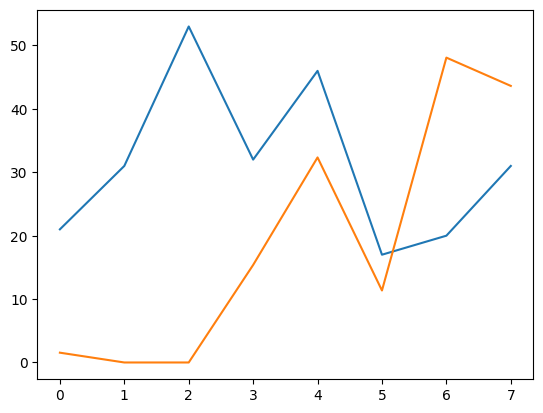

In [20]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_tensor = scaler.fit_transform(X_test_tensor)  # Normalisation des données
X_train_tensor = scaler.fit_transform(X_train_tensor)  # Normalisation des données
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)

chemin_vers_sauvegarde_model_linear ='./linear_model.pth'
device = 'cpu'
train_linear = True 
linear_model = LinearRegressionModel(dim_1=12)
n_epochs=150
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr = 0.01)
linear_model.to(device)
loss_train=[]
loss_val=[]
if train_linear:
    for epoch in (range(n_epochs)):
        # if epoch%10==0:
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for i in range(len(X_train_tensor)):
            batch_x = X_train_tensor[i]
            batch_y = y_train_tensor[i]
            counttrain+=1
            batch_x.to(device)
            batch_y.to(device)
            optimizer.zero_grad()
            batch_y_predicted = linear_model(batch_x)
            l = loss(batch_y_predicted, batch_y)
            # loggez la loss sur le batch d'entraînement
            l.backward()
            losstrain+=l.detach().numpy()
            optimizer.step()

        for i in range(len(X_test_tensor)):
            batch_x = X_test_tensor[i]
            batch_y = y_test_tensor[i]          
            countval+=1

            batch_x.to(device)
            batch_y.to(device)

            with torch.no_grad():
                batch_y_predicted = linear_model(batch_x)

                l = loss(batch_y_predicted, batch_y)
                lossval+=l.detach().numpy()

        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)

    print('Training finished')
    print('Final training loss: ', loss_train[-1])
    print('Final validation loss: ', loss_val[-1])
    plt.plot(loss_train)
    plt.plot(loss_val)
    plt.show()
    
    
    plt.plot(y_train_tensor)
    plt.plot(linear_model(X_train_tensor).detach().numpy())
    plt.show()
    plt.plot(y_test_tensor)
    plt.plot(linear_model(X_test_tensor).detach().numpy())

    
print(linear_model(X_train_tensor[1]), y_train_tensor[0])


In [21]:
for i in range(len(X_test_tensor)):
    print(linear_model(X_test_tensor[i]), y_test_tensor[i])
for i in range(len(X_train_tensor)):
    print(linear_model(X_train_tensor[i]), y_train_tensor[i])

tensor([1.5454], grad_fn=<ReluBackward0>) tensor([21.])
tensor([0.], grad_fn=<ReluBackward0>) tensor([31.])
tensor([0.], grad_fn=<ReluBackward0>) tensor([53.])
tensor([15.3831], grad_fn=<ReluBackward0>) tensor([32.])
tensor([32.3436], grad_fn=<ReluBackward0>) tensor([46.])
tensor([11.3572], grad_fn=<ReluBackward0>) tensor([17.])
tensor([48.0870], grad_fn=<ReluBackward0>) tensor([20.])
tensor([43.6267], grad_fn=<ReluBackward0>) tensor([31.])
tensor([35.0713], grad_fn=<ReluBackward0>) tensor([40.])
tensor([30.0713], grad_fn=<ReluBackward0>) tensor([33.])
tensor([27.6676], grad_fn=<ReluBackward0>) tensor([34.])
tensor([0.], grad_fn=<ReluBackward0>) tensor([26.])
tensor([20.3429], grad_fn=<ReluBackward0>) tensor([36.])
tensor([31.4752], grad_fn=<ReluBackward0>) tensor([35.])
tensor([43.9628], grad_fn=<ReluBackward0>) tensor([48.])
tensor([25.9284], grad_fn=<ReluBackward0>) tensor([22.])
tensor([24.2430], grad_fn=<ReluBackward0>) tensor([26.])
tensor([0.], grad_fn=<ReluBackward0>) tensor([1

In [24]:
model = linear_model
criterion = nn.MSELoss()
num_epochs = 100
loss_train = []
# Boucle d'entraînement : on entraîne le modèle sur chaque échantillon
for epoch in range(num_epochs):
    model.train() 

    # Apprentissage par échantillon
    for i in range(len(X_train_tensor)):  # Itération sur chaque échantillon
        # Sélection de l'échantillon i
        x_sample = X_train_tensor[i].view(1, -1)  # Redimensionnement pour correspondre à la forme (1, nb_features)
        y_sample = y_train_tensor[i].view(1, -1)  # Redimensionnement pour correspondre à la forme (1, 1)

        # Forward pass : calculer la sortie du modèle pour l'échantillon
        outputs = model(x_sample)
        loss = criterion(outputs, y_sample)
        loss_train.append(loss.item())
        # Backward pass et optimisation
        optimizer.zero_grad()  # Réinitialiser les gradients
        loss.backward()  # Calculer les gradients
        optimizer.step()  # Mettre à jour les poids

    # Affichage de la perte tous les 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Mode évaluation
model.eval()  # Mode évaluation
with torch.no_grad():
    predicted = model(X_test_tensor)  # Prédictions sur le jeu de test
    mse = criterion(predicted, y_test_tensor)  # Calcul du MSE sur le jeu de test
    print(f"Mean Squared Error (MSE) sur le test set: {mse.item():.4f}")

# Comparaison des prédictions aux vraies valeurs
predictions = predicted.numpy().flatten()
print(f"Prédictions : {predictions[:5]}")  # Afficher les premières prédictions
print(f"Vraies valeurs : {y_test[:5]}")  # Afficher les vraies valeurs

print(loss_train)

Epoch [100/100], Loss: 256.8675
Mean Squared Error (MSE) sur le test set: 197.2535
Prédictions : [26.020626  9.442953 32.029087 25.082708 32.589844]
Vraies valeurs : [21 31 53 32 46]
[24.29174041748047, 8.67655086517334, 40.43296432495117, 676.0, 247.18008422851562, 12.762907981872559, 16.258913040161133, 15.29132080078125, 3.1663997173309326, 100.0, 1.7056204080581665, 0.0024945861659944057, 3.6229913234710693, 1089.0, 1369.0, 522.2772216796875, 449.2257385253906, 1024.0, 10.773086547851562, 2401.0, 44.89716720581055, 191.14784240722656, 59.202659606933594, 1024.0, 361.0, 1296.0, 77.10163879394531, 229.02127075195312, 195.26832580566406, 88.7229232788086, 411.5564270019531, 24.633956909179688, 9.699837684631348, 41.40541458129883, 676.0, 251.57550048828125, 13.241792678833008, 16.769472122192383, 14.601637840270996, 4.016404628753662, 100.0, 1.5259332656860352, 0.047945067286491394, 4.166274070739746, 1089.0, 1369.0, 500.1236877441406, 448.3620910644531, 1024.0, 10.259961128234863, 24

In [ ]:
num_epochs = 100

# Boucle d'entraînement : on entraîne le modèle sur chaque échantillon
for epoch in range(num_epochs):
    binary_model.train()  # Mode entraînement

    # Apprentissage par échantillon
    for i in range(len(X_train_tensor)):  # Itération sur chaque échantillon
        # Sélection de l'échantillon i
        x_sample = X_train_tensor[i].view(1, -1)  # Redimensionnement pour correspondre à la forme (1, nb_features)
        y_sample = y_train_tensor_binary[i].view(1, -1)  # Redimensionnement pour correspondre à la forme (1, 1)

        # Forward pass : calculer la sortie du modèle pour l'échantillon
        outputs = binary_model(x_sample)
        loss = binary_criterion(outputs, y_sample)

        # Backward pass et optimisation
        optimizer.zero_grad()  # Réinitialiser les gradients
        loss.backward()  # Calculer les gradients
        optimizer.step()  # Mettre à jour les poids

    # Affichage de la perte tous les 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Mode évaluation
binary_model.eval()  # Mode évaluation
with torch.no_grad():
    predicted = binary_model(X_test_tensor)  # Prédictions sur le jeu de test
    bce = binary_criterion(predicted, y_test_tensor_binary)  # Calcul du MSE sur le jeu de test
    print(f"BCE sur le test set: {bce.item():.4f}")

# Comparaison des prédictions aux vraies valeurs
predictions = predicted.numpy().flatten()
print(f"Prédictions : {predictions[:5]}")  # Afficher les premières prédictions
print(f"Vraies valeurs : {y_test[:5]}")  # Afficher les vraies valeurs


Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
BCE sur le test set: 62.5000
Prédictions : [0. 0. 0. 0. 0.]


NameError: name 'y_tes' is not defined